## Feature Selection Techniques
Machine learning models are subject to the principle of Ockham's Razor (the law of Parsimony) which states that, when choosing from a collection of competing hypotheses, the one having the fewest assumptions or dependencies should be selected. In other words, simple solutions are far more likely to be correct than complex solutions. Bearing this in mind simpler machine learning models (those having a fewer number of parameters or features) are likely to generalize well while more complex machine learning models (those having a greater number of parameters or features) are likely to generalize poorly; i.e., overfit or underfit.

To that end, an important aspect of the data science process involves identifying and eliminating features that have little influence (discriminatory or predictive power) upon the independent (response) variable. This notebook will explore and demonstrate the following feature selection techniques:

- <b>Performing Manual Feature Selection:</b>
 - Forward Selection
 - Backward Selection
 - Step-Wise Selection
<br><br> 
- <b>Performing Automated Feature Selection:</b>
 - Selecting or Eliminating Features According to their Levels of Variance
 - Selecting or Eliminating Features According to their Statistical Significance
 - Selecting or Eliminating Features Using Recursive Feature Elimination (RFE)
 - Selecting or Eliminating Features Using Tree-Based Methods to Calculate Feature Importance

### Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.feature_selection import f_regression, mutual_info_regression  # Use with Regression Problems
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif  # Use with Classification Problems
from sklearn.feature_selection import VarianceThreshold, SelectFpr, SelectFdr, SelectFwe
from sklearn.feature_selection import RFE, RFECV 

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

### Load the Data

In [2]:
# Read the cleaned source file into a DataFrame.
data_dir = os.path.join(os.getcwd(), 'Data')
source_file = os.path.join(data_dir, 'WA-Telco-Customer-Churn-ML.csv')
df = pd.read_csv(source_file, header=0, index_col=0)

# Drop the Unique Identifier
df = df.drop(labels=['Customerid'], axis=1)

#### Make appropriate data type assignments.

In [3]:
def set_datatypes(dframe):
    for col in dframe.columns:
        if dframe[col].dtypes.str.startswith('int'):
            dframe[col] = pd.to_numeric(dframe[col],
                                        downcast='integer',
                                        errors='coerce')
            
        elif dframe[col].dtypes.str.startswith('float'):
            dframe[col] = pd.to_numeric(dframe[col],
                                        downcast='float',
                                        errors='coerce')
            
        elif dframe[col].dtypes == 'object':
            dframe[col] = dframe[col].astype('category')
        
    return dframe

df = set_datatypes(df)

# Validate new data type assignments.
df.dtypes

Gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
Tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

#### Separate the Independant (Predictor) Variables (X)  from the Dependant (Target, Response, or Label) Variable (y) 

In [4]:
X = df.drop(labels=['Churn'], axis=1)
y = df.Churn

### Perform Manual Feature Selection: Forward, Backward, and/or Stepwise Selection
The following code samples serve to illustrate how feature importance can be observed by experimenting with various combinations of members from an overall feature-set. Scikit-Learn includes more efficient methods for performing these selection techniques although they obscure their algorithms from the consumer.  These code samples illustrate the principles of the following feature selection techniques:
- <b>Forward feature selection</b> starts with an empty set and adds one feature at a time to observe its influence
- <b>Backward feature selection</b> starts with all the features and removes one feature at a time to observe its influence
- <b>Stepwise feature selection</b> starts with an empty set and adds one feature at a time to observe its influence; however, features that are found to have a negative influence are removed as they are encountered.

#### Technique 1: Forward Selection
Experiment by adding one column at a time and determining the influence it has on model accuracy

In [5]:
# Start with an Empty DataFrame
selected_df = pd.DataFrame()

# Instantiate a Standard Scaler
scaler = StandardScaler()

# Create new Empty list objects
accuracy_scores = []
column_names = []

for column in list(X.columns):
    # Add the next column to the new DataFrame
    selected_df[column] = X[column]
    
    # Create separate data sets for Training and Testing
    X_train, X_test, y_train, y_test = train_test_split(selected_df, y,
                                                        test_size=0.25, stratify=y, random_state=42)
    
    # Scale (Standardize) the features.
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train a Classifier using the Training data.
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)

    # Make Predictions using the Test data.
    y_pred = rfc.predict(X_test)
    
    # Append the Accuracy Score, and the Column Name to their lists
    accuracy_scores.append(accuracy_score(y_test, y_pred).round(4))
    column_names.append(column)
    
    
# Create a new DataFrame to hold the report
report = pd.DataFrame()
report['Accuracy'] = accuracy_scores
report['Column Added (Cumulative)'] = column_names

# Finally, display the report    
report.sort_values(by=['Accuracy'], ascending=False).reset_index(drop=True)

,Accuracy,Column Added (Cumulative)
0,0.7922,TotalCharges
1,0.7814,MonthlyCharges
2,0.7802,PaymentMethod
3,0.7785,PaperlessBilling
4,0.7774,Contract
5,0.7581,StreamingTV
6,0.7570,StreamingMovies
7,0.7558,Tenure
8,0.7541,OnlineSecurity
9,0.7524,OnlineBackup


#### Technique 2: Backward Selection
Experiment by removing one column at a time to observe the influence it had upon model Accuracy

In [6]:
# Start with the complete set of Independent (Predictor) features
selected_df = X

# Instantiate a Standard Scaler
scaler = StandardScaler()

# Create new Empty list objects
accuracy_scores = []
column_names = []

for column in list(X.columns):
    # Remove the next column from the DataFrame
    selected_df = X.drop(labels=[column], axis=1)
    
    # Create separate data sets for Training and Testing
    X_train, X_test, y_train, y_test = train_test_split(selected_df, y, 
                                                        test_size=0.25, stratify=y, random_state=42)
    
    # Scale (Standardize) the features.
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train a Classifier using the Training data.
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)

    # Make Predictions using the Test data.
    y_pred = rfc.predict(X_test)
    
    # Append the Accuracy Score, and the Column Name to their lists
    accuracy_scores.append(accuracy_score(y_test, y_pred).round(4))
    column_names.append(column)
    
    
# Create a new DataFrame to hold the report
report = pd.DataFrame()
report['Accuracy'] = accuracy_scores
report['Column Removed (Cumulative)'] = column_names
    
# Finally, display the report    
report.sort_values(by=['Accuracy'], ascending=False).reset_index(drop=True)

,Accuracy,Column Removed (Cumulative)
0,0.7933,Partner
1,0.7916,InternetService
2,0.7910,OnlineBackup
3,0.7910,PhoneService
4,0.7905,Gender
5,0.7893,StreamingTV
6,0.7888,Tenure
7,0.7876,MonthlyCharges
8,0.7871,MultipleLines
9,0.7871,Dependents


#### Technique 3: Step-Wise Selection
Experiment by adding features one-at-a-time to observe their influence; removing features causing accuracy degradation as they are encountered, and before adding any subsequent features.

In [7]:
# Start with an Empty DataFrame
selected_df = pd.DataFrame()

# Instantiate a Standard Scaler
scaler = StandardScaler()

# Create new Empty list objects
accuracy_scores = []
column_names = []

i = 0

for column in list(X.columns):
    # Add the next column to the new DataFrame
    selected_df[column] = X[column]
    
    # Create separate data sets for Training and Testing
    X_train, X_test, y_train, y_test = train_test_split(selected_df, y, 
                                                        test_size=0.25, stratify=y, random_state=42)
    
    # Scale (Standardize) the features.
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train a Classifier using the Training data.
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)

    # Make Predictions using the Test data.
    y_pred = rfc.predict(X_test)
    
    # Append the Accuracy Score, and the Column Name to their lists
    accuracy = accuracy_score(y_test, y_pred).round(4)
    accuracy_scores.append(accuracy)
    column_names.append(column)
    
    # Record the previous iteration
    j = (i-1)
    
    # Remove any columns whose scores are lesser than previous columns' scores
    if accuracy < accuracy_scores[j]:
        accuracy_scores.remove(accuracy)
        column_names.remove(column)
        print("Removed Column [{0}] Having Score: {1}".format(column, accuracy))
        i -= 1    # Decrement
        
    # Increment
    i += 1
    

# Create a new DataFrame to hold the report
report = pd.DataFrame()
report['Accuracy'] = accuracy_scores
report['Column Added (Cumulative)'] = column_names
   
# Finally, display the report    
report  #.sort_values(by=['Accuracy'], ascending=False).reset_index(drop=True)

Removed Column [PhoneService] Having Score: 0.7422
Removed Column [MultipleLines] Having Score: 0.7365
Removed Column [InternetService] Having Score: 0.7524
Removed Column [OnlineSecurity] Having Score: 0.7541
Removed Column [OnlineBackup] Having Score: 0.7524
Removed Column [DeviceProtection] Having Score: 0.7484
Removed Column [TechSupport] Having Score: 0.749
Removed Column [StreamingMovies] Having Score: 0.757


,Accuracy,Column Added (Cumulative)
0,0.7348,Gender
1,0.7348,SeniorCitizen
2,0.7348,Partner
3,0.7348,Dependents
4,0.7558,Tenure
5,0.7581,StreamingTV
6,0.7774,Contract
7,0.7785,PaperlessBilling
8,0.7802,PaymentMethod
9,0.7814,MonthlyCharges


### Performing Automated Feature Selection:
#### Technique 1: Eliminate Features Having Low Variance; e.g., Less than a Threshold (Sigma)
Features having the same value in a high percentage of observations typically have little influence. Using this technique we aim to identify those features (columns) where a specified percentage of their observations contain the same value. The statistical formula for calculating variance (sigma) is: Var[X] = p(1-p) where 'p' is the percentage threshold.

<b>The first step</b> is to learn the variances of each feature and create a reduced feature-set:

In [8]:
# Calculate 80% Variance: Var[X] = p(1-p)
p = 0.8
sigma = p * (1-p)

print("Sigma: {0}:".format(str(sigma)))

# Fit (learn) the Variances and Transform the Input (X) to a Reduced Version 
selector = VarianceThreshold(threshold=(sigma))
selected = selector.fit_transform(X)

Sigma: 0.15999999999999998:


##### Step 2: Identify Which Features Should Be Excluded

In [9]:
selected_mask = selector.get_support(indices=False)  # 'indices=False' returns a Boolean array
deselected_labels = list(X.columns[~selected_mask])  # The ~ operator acts as a negator

print("The Following Features Have Low Variance and Should Be Removed:", deselected_labels)

The Following Features Have Low Variance and Should Be Removed: ['SeniorCitizen', 'PhoneService']


##### Step 3: Create a Pandas DataFrame Containing the Features that Should Be Retained

In [10]:
selected_index = selector.get_support(indices=True)     # 'indices=True' returns an index array

# Get the Column Names that Correspond to the Indices
selected_labels = list(X.columns[selected_index])

# Create a New Pandas DataFrame Using the New Values and Column Names
X_selected = pd.DataFrame(data=selected, columns=selected_labels)

print("The Remaining {0} of the {1} Features Have Sufficient Variance:".format(X_selected.shape[1], X.shape[1]))

X_selected.head()

The Remaining 17 of the 19 Features Have Sufficient Variance:


,Gender,Partner,Dependents,Tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,29.85,29.85
1,1.0,0.0,0.0,34.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,56.95,1889.50
2,1.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,53.85,108.15
3,1.0,0.0,0.0,45.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,42.30,1840.75
4,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.70,151.65


#### Technique 2: Univariate Feature Selection (Eliminiating Statistically Insignificant Features)
Univariate feature selection is aimed at identifying the most influential features by performing a battery of univariate tests wherein each feature is evaluated for its statistical significance. Represented by the <b>P-Value</b> metric, statistical significance refers to the probability that a newly observed value will be more extreme than a predetermined threshold (alpha). While alpha isn't an absolute, 5% (0.05) is very common. In other words, if the probability of observing a new value that's more extreme than what has already been observed exceeds 5% then that feature should be excluded.  

<b>The first step</b> is to calculate the F1 and P-Value scores for each feature:
 - The <b>f_regression</b> and <b>mutual_info_regression</b> libraries are used for solving Regression problems.
 - The <b>chi2, f_classif</b> and <b>mutual_info_classif</b> libraries are used for solving Classification problems.

In [11]:
f1, p_val = f_classif(X, y)  # This example is a Classification problem...

##### Next, Plot the Features to Visualize their P-Values

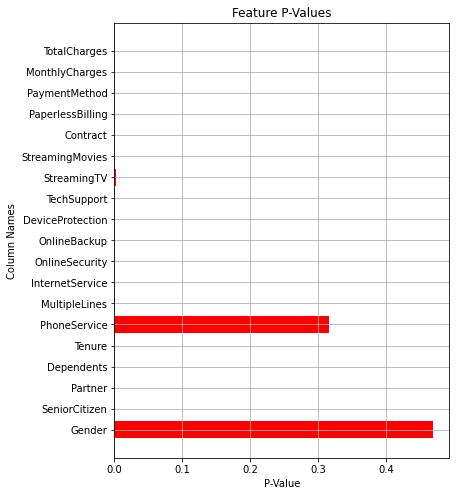

In [12]:
#  Create a numpy array as big as the collection of features
index = np.arange(0, X.shape[1])

# Calculate Appropriate Dimensions and Create the Plot
height = round(X.shape[1] * 0.4)
width = round(height * 0.8)

fig, ax = plt.subplots(figsize=(width, height))

# Associate the Feature (column) Names with each member of the array.
plt.yticks(index, X.columns)

# Pass the Numpy array, and the array of P-Values to the Bar Plot function.
ax.barh(index, p_val, color='r')

# Set values for the plot's Title, X labels and Y labels.
ax.set_title("Feature P-Values")
ax.set_ylabel("Column Names")
ax.set_xlabel("P-Value")
ax.grid(True)

##### Step 2: Use the P-Values to Identify the Statistically Insignificant Features; i.e., P-Value > Alpha

In [13]:
alpha = 0.05

insig_index = index[p_val > alpha]
insig_labels = list(X.columns[insig_index])

print("The Following '{0}' Statistically Insignificant Features Should Be Dropped:".format(len(insig_index)))
print(insig_labels)

The Following '2' Statistically Insignificant Features Should Be Dropped:
['Gender', 'PhoneService']


##### Step 3: Drop the Insignificant Features from the DataFrame (X).

In [14]:
X_significant = X.drop(labels=insig_labels, axis=1)

print("The Remaining {0} of {1} Features are Statistically Significant:".format(len(X_significant.columns), len(X.columns)))

X_significant.head()

The Remaining 17 of 19 Features are Statistically Significant:


,SeniorCitizen,Partner,Dependents,Tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,1,0,1,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,0,0,0,34,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50
2,0,0,0,2,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15
3,0,0,0,45,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75
4,0,0,0,2,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65


#### Techique 3: Univariate Feature Selection (Eliminate Features Using Family-Wise Error Rate (FWE))
Univariate feature selection is aimed at identifying the most influential features by performing univariate tests for statistical significance. This method selects the p-values corresponding to Family-wise error rate. SciKit-Learn also provides libraries that enable implementing this technique to select p-values relevant to False Positive Rate (FPR) and False Discovery Rate (FDR).

In [15]:
selector = SelectFwe(f_classif, alpha=0.05)
selected = selector.fit_transform(X, y)

##### Step 2: Identify Which Features Should Be Excluded

In [16]:
selected_mask = selector.get_support(indices=False)  # 'indices=False' returns a Boolean array
deselected_labels = list(X.columns[~selected_mask])  # The ~ operator acts as a negator

print("The Following Features are Insignificant and Should Be Removed:", deselected_labels)

The Following Features are Insignificant and Should Be Removed: ['Gender', 'PhoneService']


##### Step 3: Create a Pandas DataFrame Containing the Features that Should be Retained

In [17]:
selected_index = selector.get_support(indices=True)     # 'indices=True' returns an index array

# Get the Column Names that Correspond to the Indices
selected_labels = list(X.columns[selected_index])

# Create a New Pandas DataFrame Using the New Values and Column Names
X_selected = pd.DataFrame(data=selected, columns=selected_labels)

print("The Remaining {0} of the {1} Features are Significant:".format(X_selected.shape[1], X.shape[1]))

X_selected.head()

The Remaining 17 of the 19 Features are Significant:


,SeniorCitizen,Partner,Dependents,Tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,29.85,29.85
1,0.0,0.0,0.0,34.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,56.95,1889.50
2,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,53.85,108.15
3,0.0,0.0,0.0,45.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,42.30,1840.75
4,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.70,151.65


#### Technique 4: Recursive Feature Elimination (RFE)
Much like the 'Backward Selection' technique illustrated above, Recursive Feature Elimination (RFE) selects the most influential features by recursively considering increasingly smaller feature-sets. Internally, the RFE library implements what is essentially the same algorithm; first training an estimator using all of the features contained in the dataset to obtain the relative importance of each feature as indicated by its coefficient. It then prunes the least important features. This process is recursively repeated until the specified number of features is identified.

##### Step 1: Fit a Recursive Feature Elimination (RFE) Model

In [18]:
# Create a base classifier used to evaluate a subset of attributes
model = RandomForestClassifier(random_state=42)
rfe = RFE(model, 6)
rfe = rfe.fit(X, y)

print("There are {0} features selected".format(rfe.n_features_))

There are 6 features selected


##### Step 2: Display the Selected Features

In [19]:
selected_mask = rfe.support_
selected_labels = X.columns[selected_mask]
ranking = rfe.ranking_
selected = list(zip(ranking, selected_labels))

# Create a New Pandas DataFrame Using the Ranks and Feature Names
X_selected = pd.DataFrame(selected, columns=['Ranking','Feature'])
X_selected.sort_values(['Ranking']).reset_index(drop=True)

,Ranking,Feature
0,1,MonthlyCharges
1,5,Tenure
2,8,Contract
3,10,OnlineSecurity
4,11,PaymentMethod
5,14,TotalCharges


#### Technique 5: Tree-Based Feature Selection
Both decision tree-based estimators and forest of trees (ensemble) based estimators can be used to calculate feature importance. This metric enables making quantifiable decisions regarding which features can be discarded without significant negative impact. This approach is functionally equivalent to the 'Forward Selection' method illustrated above.

##### Step 1: Fit a Tree or Ensemble Based Classifier

In [20]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X, y)

# Invoke the method to fetch the feature importances
data = list(zip(X.columns, rfc.feature_importances_))

##### Step 2: Display All the Features Ordered by Their Relative Importance

In [21]:
X_importance = pd.DataFrame(data, columns=['Feature','Importance'])
X_importance.sort_values(by=['Importance'], ascending=False).reset_index(drop=True)

,Feature,Importance
0,TotalCharges,0.190900
1,MonthlyCharges,0.178999
2,Tenure,0.158299
3,Contract,0.077508
4,PaymentMethod,0.051479
5,TechSupport,0.045127
6,OnlineSecurity,0.043762
7,InternetService,0.027714
8,Gender,0.027378
9,OnlineBackup,0.026819


##### Step 3: Display a Plot to Visualize Which Features to Eliminate

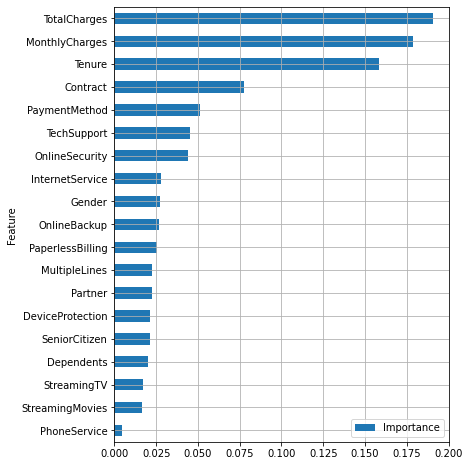

In [22]:
# Calculate Appropriate Dimensions and Create the Plot
height = round(X.shape[1] * 0.4)
width = round(height * 0.8)

X_importance.sort_values(by=['Importance'], ascending=True).plot.barh(x='Feature', figsize=(width, height)).grid(True)

###### Step 4: Drop Features Having an Importance Below a Specified Threshold

In [23]:
excluded_labels = list(X_importance[X_importance.Importance < 0.04].Feature)
print("The Following {0} Features are Insignificant and Should Be Removed:{1}".format(len(excluded_labels), excluded_labels))

X = X.drop(labels=excluded_labels, axis=1)
X.head()

The Following 12 Features are Insignificant and Should Be Removed:['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']


,Tenure,OnlineSecurity,TechSupport,Contract,PaymentMethod,MonthlyCharges,TotalCharges
0,1,0,0,0,2,29.85,29.85
1,34,2,0,1,3,56.95,1889.50
2,2,2,0,0,3,53.85,108.15
3,45,2,2,1,0,42.30,1840.75
4,2,0,0,0,2,70.70,151.65
